In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
import tensorflow as tf

import matplotlib.pyplot as plt



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [3]:
# Load dataset
img_height = 224
img_width = 224
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Example: show class names
print("Classes:", train_ds.class_names)

Found 7023 files belonging to 2 classes.
Classes: ['Testing', 'Training']


In [4]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [5]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
 for image in os.listdir(os.path.join(train_dir,label)):
  train_paths.append(os.path.join(train_dir,label,image))
  train_labels.append(label)


train_paths, train_labels = shuffle(train_paths, train_labels)

In [6]:
print(train_paths[0])

/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0100.jpg


In [7]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
 for image in os.listdir(os.path.join(test_dir,label)):
  test_paths.append(os.path.join(test_dir,label,image))
  test_labels.append(label)


test_paths, test_labels = shuffle(test_paths, test_labels)

In [8]:
print(test_paths[0])

/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0325.jpg


In [9]:
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

[4351, 1360, 3117, 4365, 817, 5548, 2930, 4988, 935, 5067]

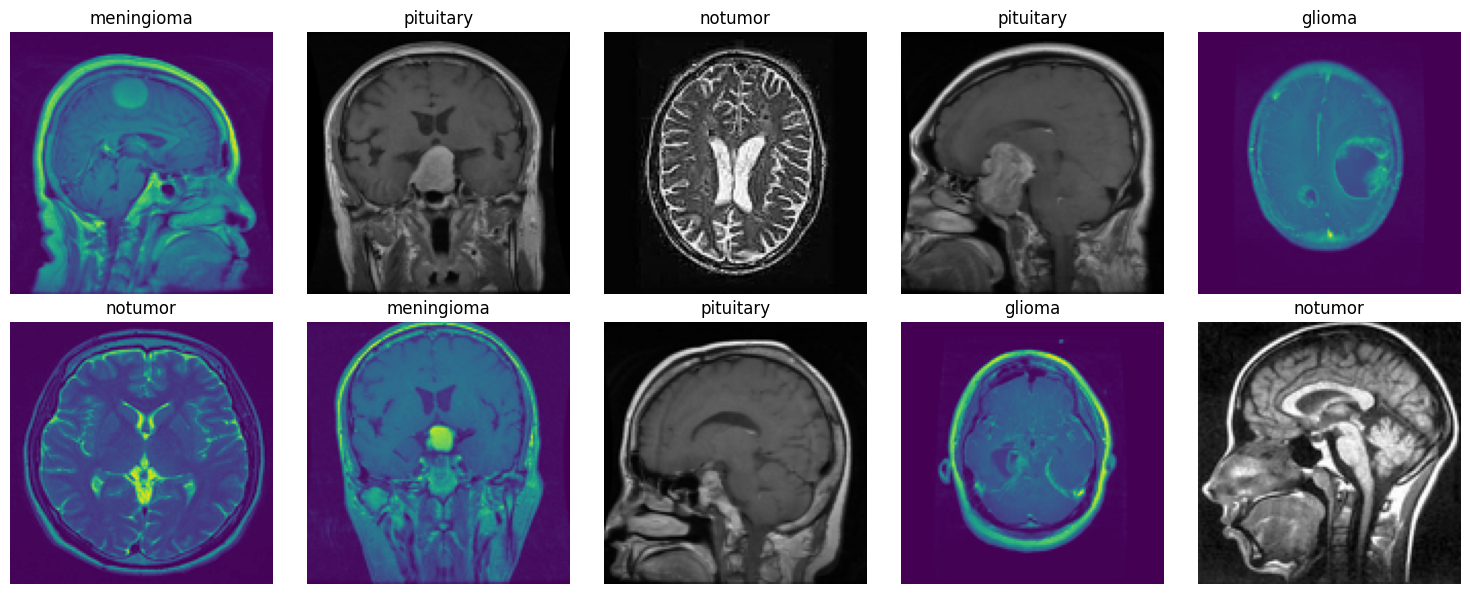

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, index in enumerate(random_indices):
 img_path = train_paths[index]
 img = Image.open(img_path)
 img = img.resize((128,128))
 axes[i].imshow(img)
 axes[i].set_title(train_labels[index])
 axes[i].axis('off')

plt.tight_layout()
plt.show()


In [13]:


def augment_image(image):
   image = Image.fromarray(np.uint8(image))
   image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
   image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
   image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))

   image = np.array(image)/255.0
   return image


def open_images(paths):
  image= []
  for path in paths:
    img = load_img(path, target_size = (image_size, image_size))
    img = augment_image(img)
    image.append(img)
  return np.array(image)


def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))
    encoded_labels = [unique_labels.index(label) for label in labels]
    return np.array(encoded_labels)


def datagen(path,label,batch_size = 12, epochs = 1):
  for _ in range(epochs):
    for i in range(0, len(path), batch_size):
      batch_paths = path[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = label[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield (batch_images, batch_labels)



In [14]:
image_size = 128
base_model = VGG16(input_shape = (image_size, image_size,3), include_top = False, weights = 'imagenet')


for layer in base_model.layers:
  layer.trainable = False


base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape = (image_size, image_size,3))) #input layer
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax'))

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])


batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 6

history = model.fit(
    datagen(train_paths, train_labels, batch_size = batch_size, epochs = epochs),
    steps_per_epoch = steps,
    epochs = epochs
)
model.summary()

Epoch 1/6
285/285 ━━━━━━━━━━━━━━━━━━━━ 1384s 5s/step - loss: 0.7010 - sparse_categorical_accuracy: 0.7267
Epoch 2/6
285/285 ━━━━━━━━━━━━━━━━━━━━ 1342s 5s/step - loss: 0.2555 - sparse_categorical_accuracy: 0.9001
Epoch 3/6
285/285 ━━━━━━━━━━━━━━━━━━━━ 1396s 5s/step - loss: 0.1819 - sparse_categorical_accuracy: 0.9379
Epoch 4/6
285/285 ━━━━━━━━━━━━━━━━━━━━ 1335s 5s/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9496
Epoch 5/6
285/285 ━━━━━━━━━━━━━━━━━━━━ 1331s 5s/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9709
Epoch 6/6
285/285 ━━━━━━━━━━━━━━━━━━━━ 1336s 5s/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9701


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,168,846 (134.16 MB)

 Trainable params: 9,177,860 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 18,355,722 (70.02 MB)

<ipython-input-15-178f77f4d9e6>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


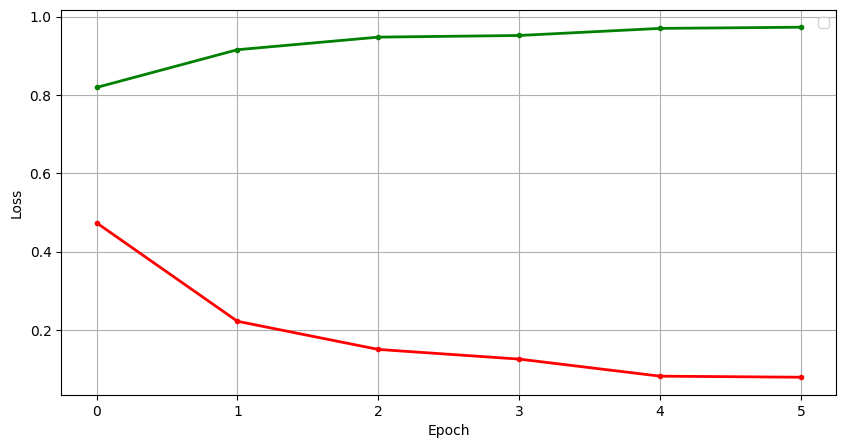

In [15]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels = encode_label(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 277s 7s/step


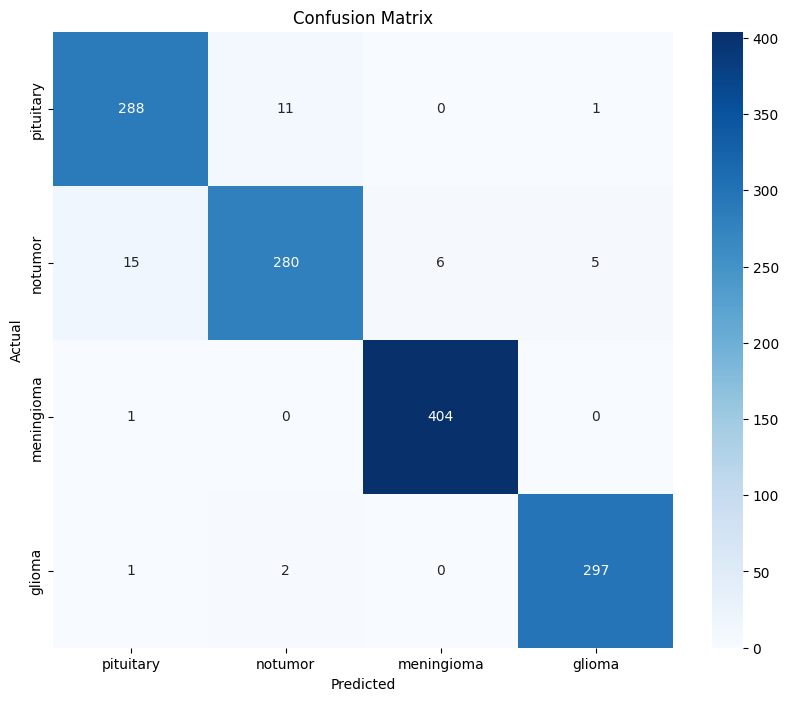

In [21]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
model.save("tumor_detection_model.h5")  # Saves in HDF5 format


In [49]:
from keras.preprocessing.image import load_img, img_to_array  # fixed typo in import

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(image_path, model):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        confidence_score = np.max(prediction)

        # Interpret the prediction
        predicted_class_label = class_labels[predicted_class_index]
        if predicted_class_label == 'notumor':
            result = "No Tumor Detected"
        else:
            result = f"Tumor: {predicted_class_label}"

        # Display image with prediction
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {(confidence_score - .01) * 100:.2f} %)")
        plt.show()

    except Exception as e:
        result = f"Error: {str(e)}"

    return result


Testing: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


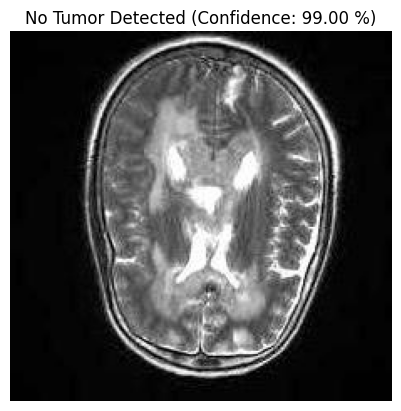

No Tumor Detected
Testing: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


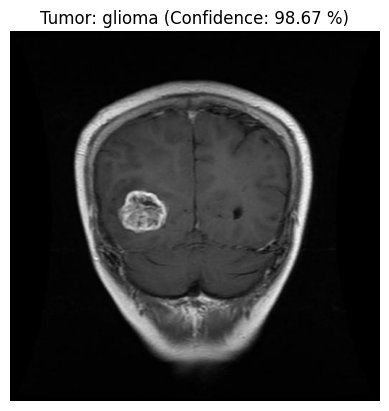

Tumor: glioma
Testing: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


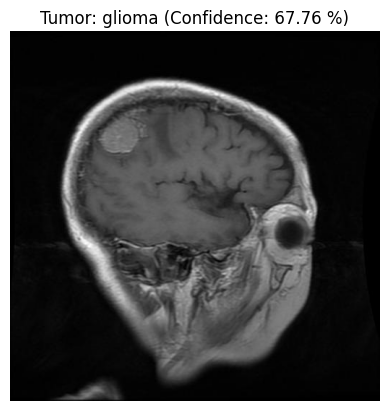

Tumor: glioma
Testing: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


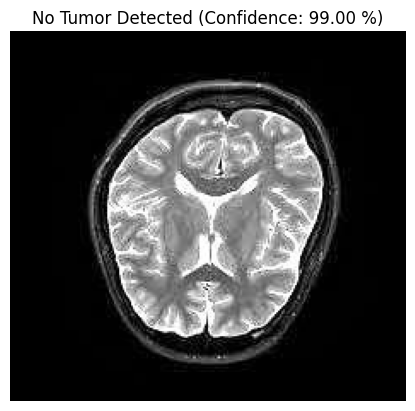

No Tumor Detected
Testing: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


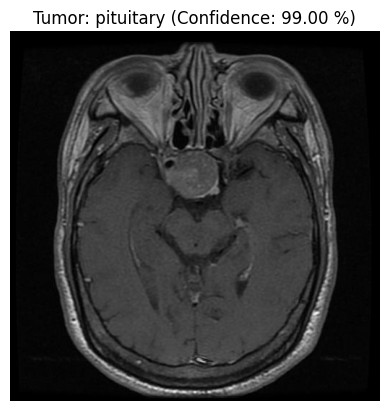

Tumor: pituitary


In [50]:
sample_paths = random.sample(test_paths, 5)

for img_path in sample_paths:
    print("Testing:", img_path)
    result = detect_and_display(img_path, model)
    print(result)


In [57]:
from keras.models import Model
import cv2
import matplotlib.cm as cm


In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Build a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with regard to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, model, class_labels, last_conv_layer_name=None):
    # If last_conv_layer_name is not specified, try to find the last conv layer
    if last_conv_layer_name is None:
        for layer in reversed(model.layers[0].layers):  # Iterate through base_model layers
            if 'conv' in layer.name:
                last_conv_layer_name = layer.name
                print(f"Using '{last_conv_layer_name}' as the last convolutional layer")
                break

    # Load and preprocess the image
    img = load_img(image_path, target_size=(image_size, image_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(prediction[0])
    confidence_score = prediction[0][predicted_class_index]
    predicted_class_label = class_labels[predicted_class_index]

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load the original image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (image_size, image_size))

    # Convert heatmap to RGB
    heatmap = cv2.resize(heatmap, (image_size, image_size))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cm.jet(heatmap)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # Display the original image and the Grad-CAM visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(original_img)
    axes[0].set_title(f"{predicted_class_label} (Confidence: {confidence_score * 100:.2f}%)")
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title("Grad-CAM Activation")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return predicted_class_label, confidence_score

# Function to run Grad-CAM on multiple test images
def analyze_samples_with_gradcam(test_paths, model, class_labels, num_samples=5):
    # Get a random sample of test images
    sample_paths = random.sample(test_paths, num_samples)

    # Find last conv layer
    last_conv_layer_name = None
    for layer in reversed(model.layers[0].layers):
        if 'conv' in layer.name:
            last_conv_layer_name = layer.name
            print(f"Using '{last_conv_layer_name}' as the last convolutional layer")
            break

    # Display Grad-CAM for each sample
    for i, img_path in enumerate(sample_paths):
        print(f"\n🔍 Image {i+1}: {img_path}")
        class_name, confidence = display_gradcam(img_path, model, class_labels, last_conv_layer_name)
        if class_name == 'notumor':
            result = "No Tumor Detected"
        else:
            result = f"Tumor Type: {class_name}"
        print(f"Prediction: {result} (Confidence: {confidence * 100:.2f}%)")

# Usage example:
# class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
# analyze_samples_with_gradcam(test_paths, model, class_labels, num_samples=5)


🔍 Image 1: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0255.jpg
Generating occlusion map... (this may take a minute)


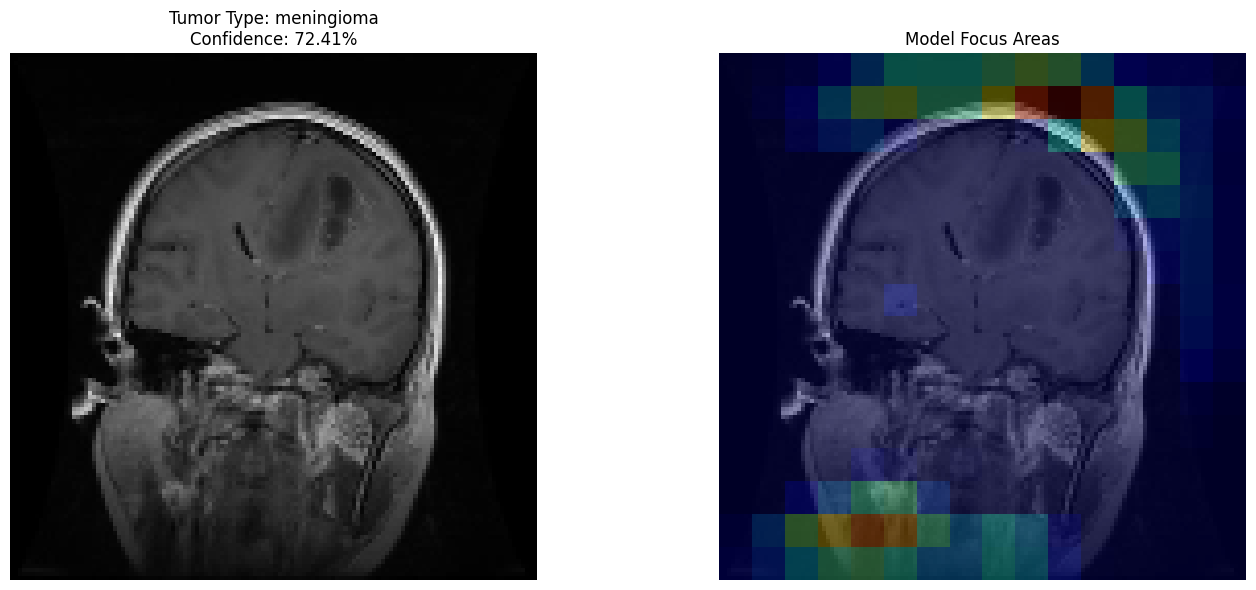

Prediction: Tumor Type: meningioma (Confidence: 72.41%)

🔍 Image 2: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0263.jpg
Generating occlusion map... (this may take a minute)


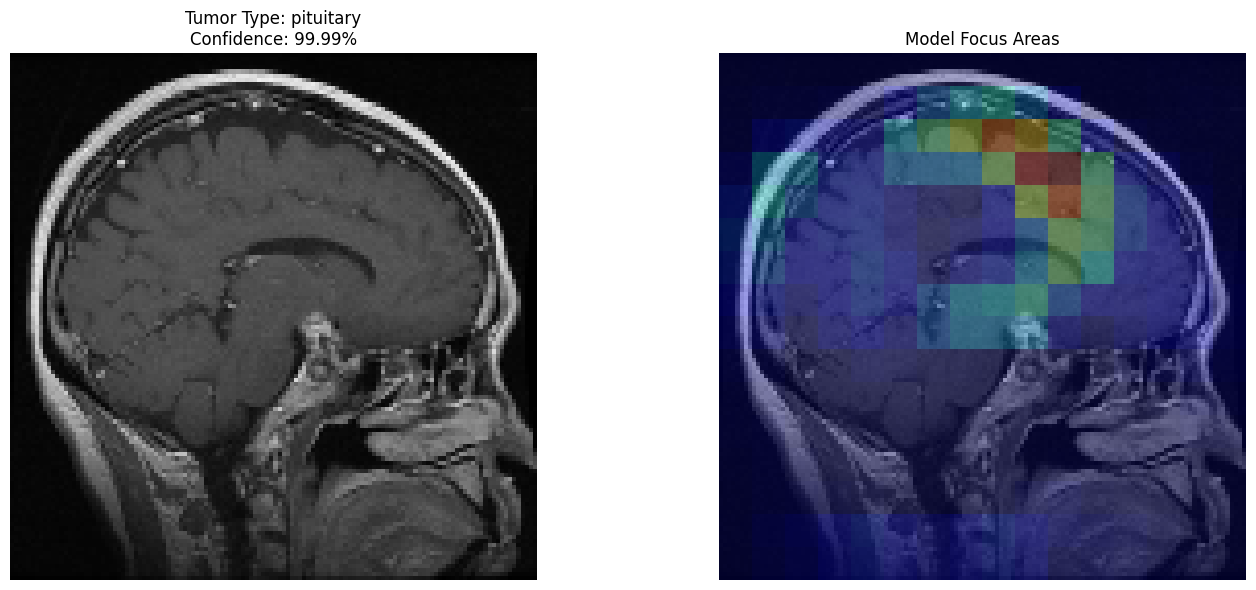

Prediction: Tumor Type: pituitary (Confidence: 99.99%)

🔍 Image 3: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0288.jpg
Generating occlusion map... (this may take a minute)


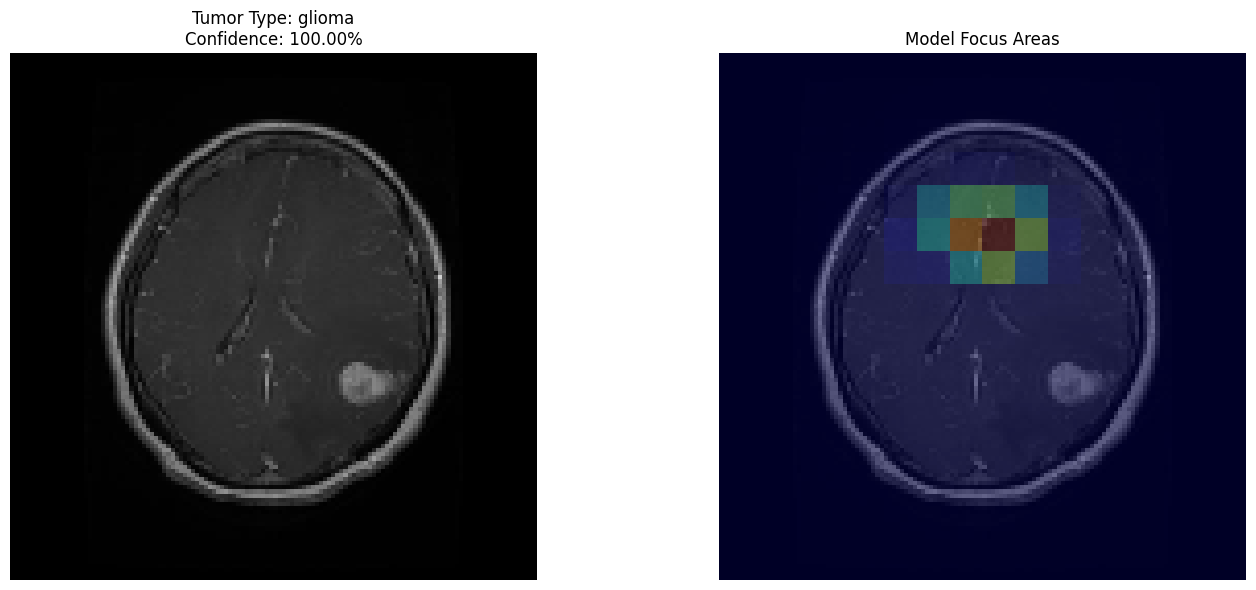

Prediction: Tumor Type: glioma (Confidence: 100.00%)

🔍 Image 4: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0175.jpg
Generating occlusion map... (this may take a minute)


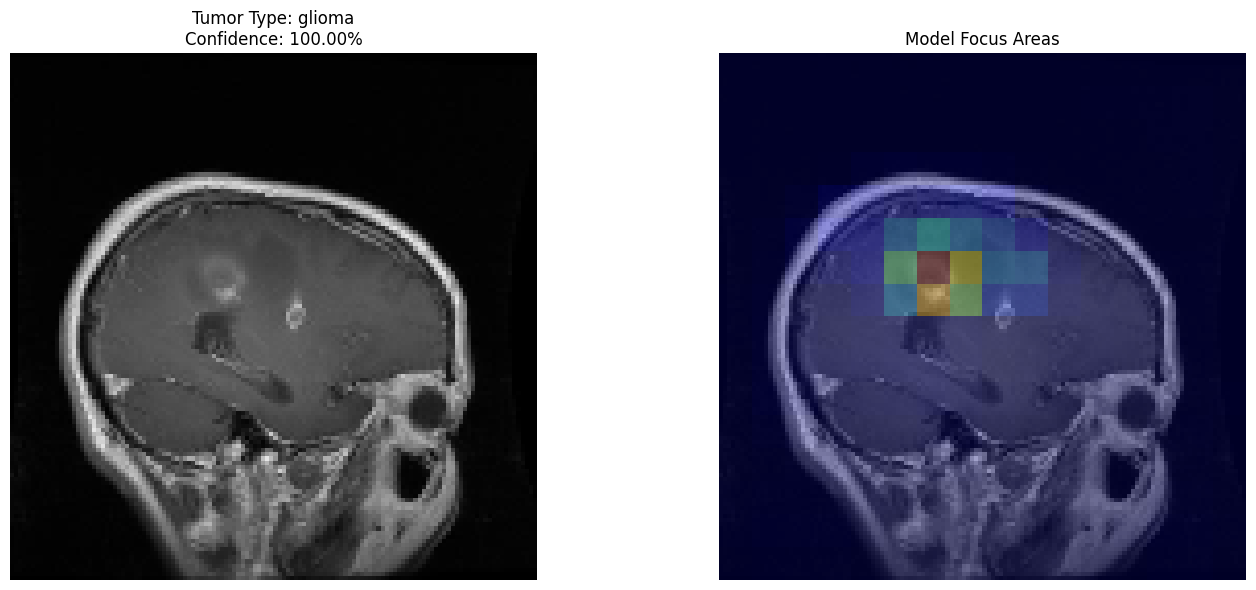

Prediction: Tumor Type: glioma (Confidence: 100.00%)

🔍 Image 5: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0199.jpg
Generating occlusion map... (this may take a minute)


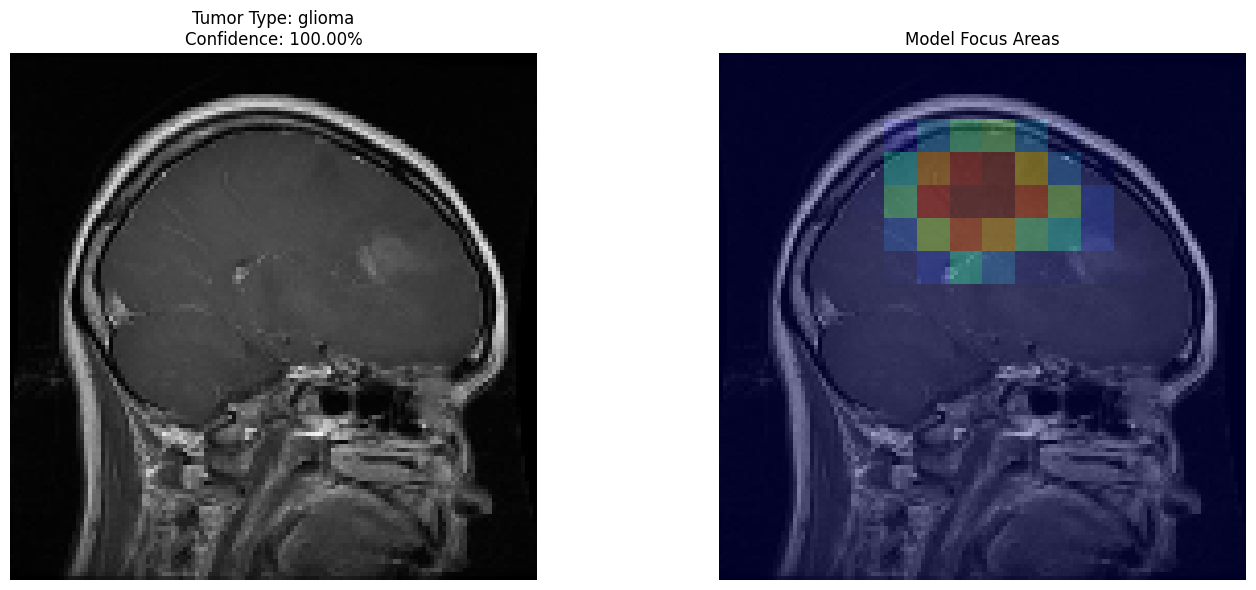

Prediction: Tumor Type: glioma (Confidence: 100.00%)


In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import random

# Define class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def generate_occlusion_map(model, img_array, class_idx, patch_size=16, stride=8):
    """
    Generate an occlusion sensitivity map by sliding a patch over the image
    and measuring how the prediction changes when parts are occluded.
    """
    # Get the original image shape
    height, width, _ = img_array.shape[1:]

    # Initialize a heatmap with zeros
    heatmap = np.zeros((height, width))

    # Get original prediction probability for the target class
    original_pred = model.predict(img_array, verbose=0)[0][class_idx]

    # Slide the patch across the image
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Create a copy of the image
            occluded_img = img_array.copy()

            # Replace the patch with gray (0.5)
            occluded_img[0, y:y+patch_size, x:x+patch_size, :] = 0.5

            # Get new prediction
            new_pred = model.predict(occluded_img, verbose=0)[0][class_idx]

            # Calculate how much the prediction changed (decrease is important)
            pred_diff = original_pred - new_pred

            # Update the heatmap (larger difference = more important region)
            heatmap[y:y+patch_size, x:x+patch_size] += pred_diff

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    return heatmap

# Test on 5 random images
random_samples = random.sample(test_paths, 5)

for i, img_path in enumerate(random_samples):
    print(f"\n🔍 Image {i+1}: {img_path}")

    # Load and preprocess the image
    img = load_img(img_path, target_size=(image_size, image_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    class_idx = np.argmax(prediction[0])
    confidence_score = prediction[0][class_idx]
    predicted_label = class_labels[class_idx]

    # Display status message
    print(f"Generating occlusion map... (this may take a minute)")

    # Generate occlusion sensitivity map (use smaller patch for greater detail)
    occlusion_map = generate_occlusion_map(model, img_array, class_idx,
                                           patch_size=16, stride=8)

    # Load the original image
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (image_size, image_size))

    # Resize occlusion map to match image size
    occlusion_map = cv2.resize(occlusion_map, (image_size, image_size))

    # Convert heatmap to RGB using a colormap
    heatmap_colored = plt.cm.jet(occlusion_map)[:, :, :3]
    heatmap_colored = np.uint8(255 * heatmap_colored)

    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(original_img, 0.7, heatmap_colored, 0.3, 0)

    # Display the original image and the visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Show original image
    axes[0].imshow(original_img)
    if predicted_label == 'notumor':
        result = "No Tumor Detected"
    else:
        result = f"Tumor Type: {predicted_label}"
    axes[0].set_title(f"{result}\nConfidence: {confidence_score * 100:.2f}%", fontsize=12)
    axes[0].axis('off')

    # Show visualization
    axes[1].imshow(superimposed_img)
    axes[1].set_title("Model Focus Areas", fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print prediction information
    print(f"Prediction: {result} (Confidence: {confidence_score * 100:.2f}%)")